# Лабораторная работа №2

## Задания

1. Провести моделирование временного ряда из задачи 1 с помощью нейросетевых методов на свой выбор.
2. Смоделировать ряд, сделав предсказание на разумный период.
3. Провести анализ метрик.
4. Изобразить график модели с предсказанием с учетом возможных ошибок.
5. Сделать заключение, сравнив результаты

## Реализация

### Задание 1. Генерация ряда и выбор нейросетевого метода

#### Генерация

In [1]:
import numpy as np
from datetime import datetime, timedelta


def generate_time_series(n_points=1000, has_trend=True, has_seasonality=True, seed=None):
    """
    Генерирует временной ряд со случайными параметрами без использования
    Pandas
    Параметры:
    ----------
    n_points : int
    Количество точек данных
    has_trend : bool
    Добавлять ли тренд
    has_seasonality : bool
    Добавлять ли сезонность
    seed : int или None
    Seed для воспроизводимости
    Возвращает:
    -----------
    tuple: (dates, values) где dates - список строк дат, values - список
    значений
    """
    
    if seed is not None:
        np.random.seed(seed)
        
    # Генерируем временные метки (ежедневные данные начиная с 2020-01-01)
    start_date = datetime(2020, 1, 1)
    dates = [(start_date + timedelta(days=i)).strftime('%Y-%m-%d') for i in range(n_points)]
    
    # Базовый шум (случайная компонента)
    noise = np.random.normal(0, 5, n_points)
    
    # Инициализируем компоненты
    trend_component = np.zeros(n_points)
    seasonal_component = np.zeros(n_points)
    
    # Генерируем тренд, если требуется
    if has_trend:
        # Случайно выбираем тип тренда: линейный, квадратичный или логарифмический
        trend_type = np.random.choice(['linear', 'quadratic', 'logarithmic'])

        if trend_type == 'linear':
            # Линейный тренд: y = mx + b
            slope = np.random.uniform(-0.5, 0.5) # случайный наклон
            intercept = np.random.uniform(50, 100) # случайное начальное значение
            trend_component = slope * np.arange(n_points) + intercept
            
        elif trend_type == 'quadratic':
            # Квадратичный тренд: y = ax^2 + bx + c
            a = np.random.uniform(-0.001, 0.001)
            b = np.random.uniform(-0.1, 0.1)
            c = np.random.uniform(50, 100)
            x = np.arange(n_points)
            trend_component = a * x**2 + b * x + c
            
        else: # logarithmic
            # Логарифмический тренд: y = a*log(x+1) + b
            a = np.random.uniform(10, 30)
            b = np.random.uniform(50, 100)
            trend_component = a * np.log(np.arange(n_points) + 1) + b
        
    # Генерируем сезонность, если требуется
    if has_seasonality:
        # Случайное количество сезонных компонент (1-3)
        n_seasons = np.random.randint(1, 4)
        
        for _ in range(n_seasons):
            # Случайные параметры для каждой сезонной компоненты
            amplitude = np.random.uniform(10, 30) # амплитуда
            period = np.random.uniform(30, 365) # период в днях
            phase = np.random.uniform(0, 2*np.pi) # фаза
            
            # Создаем сезонную компоненту (синусоида)
            seasonal_component += amplitude * np.sin(2*np.pi*np.arange(n_points)/period + phase)
        
    # Комбинируем все компоненты
    values = noise + trend_component + seasonal_component
    
    return dates, values

In [2]:
days = 1000  # изначальный ряд
days_forecast = 100  # сколько дней предсказываем

dates_total, values_total = generate_time_series(n_points=days+days_forecast, seed=2)  # генерируем сразу все дни для сравнения метрик

dates, values = dates_total[:-days_forecast], values_total[:-days_forecast]
dates_forecast, values_true = dates_total[-days_forecast:], values_total[-days_forecast:]

#### Отрисовка

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline


def plot_time_series(dates, values, figsize=(14, 6)):
    """
    Визуализирует временной ряд без использования Pandas
    Параметры:
    ----------ряда
    dates : list
    Список дат в строковом формате
    values : list или np.array
    Список значений временного ряда
    figsize : tuple
    Размер фигуры
    """
    
    # Преобразуем строки дат в объекты datetime для matplotlib
    date_objects = [datetime.strptime(date_str, '%Y-%m-%d') for date_str in dates]
    
    plt.figure(figsize=figsize)
    
    # Строим график временного ряда
    plt.plot(date_objects, values, label='Временной ряд', color='blue', linewidth=1.5)
    plt.title('Сгенерированный временной ряд', fontsize=16, fontweight='bold')
    plt.xlabel('Дата', fontsize=12)
    plt.ylabel('Значение', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Автоматически форматируем ось X для дат
    plt.gcf().autofmt_xdate()
    
    # Добавляем информацию о данных
    values_array = np.array(values)
    stats_text = f"Всего точек: {len(values)}\nСреднее: {np.mean(values_array):.2f}\nСтандартное отклонение: {np.std(values_array):.2f}"
    plt.figtext(0.02, 0.02, stats_text, fontsize=10, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.7))
    
    plt.tight_layout()
    
    plt.show()

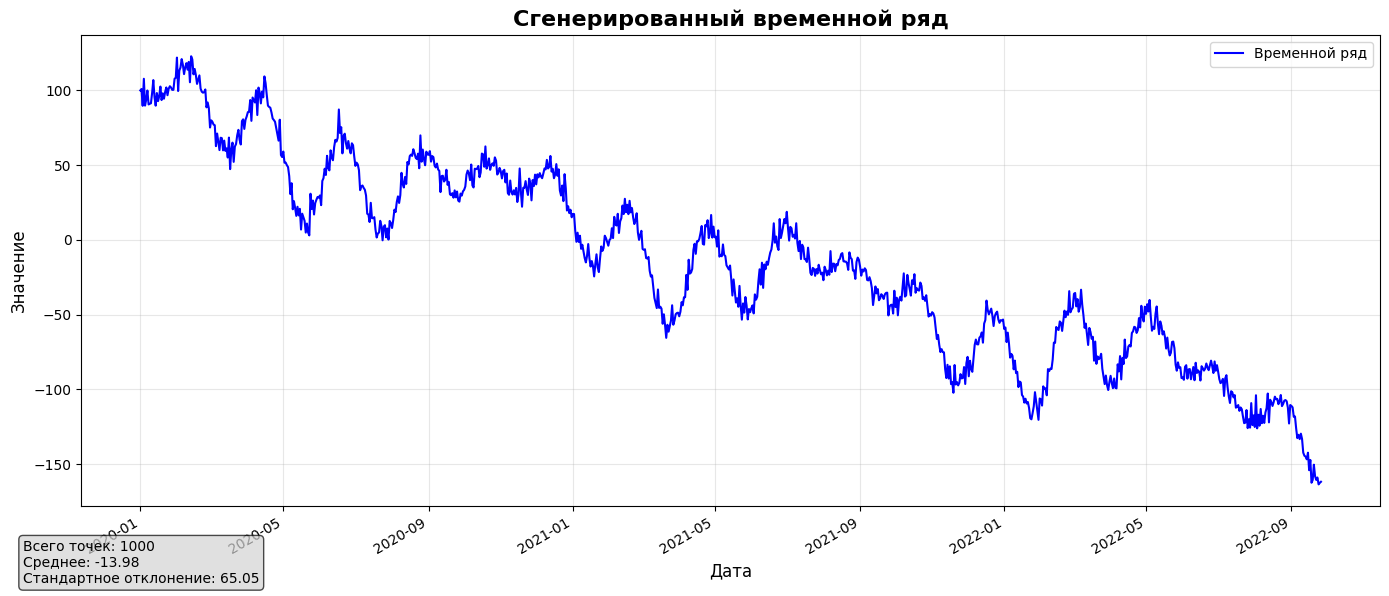

In [4]:
plot_time_series(dates, values)

#### Выбор нейросетевого метода

Для решения данной задачи я решил использовать свёрточную сеть (CNN), т.к. её проще всего реализовать для данного временного ряда.

### Задание 2. Моделирование и предсказание

#### Разделение временного ряда

Т.к. данный ряд является нестационарным (было показано в прошлой лабораторной), то перед применением CNN его лучше привести к стационарному, убрав сезонность и тренд

Это также положительно скажется на свёрточной сети, т.к. нам не придётся брать слишком много временных шагов для покрытия сезонности, что в свою очередь ухудшило бы точность

После прогноза, сезонность и тренд будут включены обратно в предсказание также, как это было сделано в 1 лабе

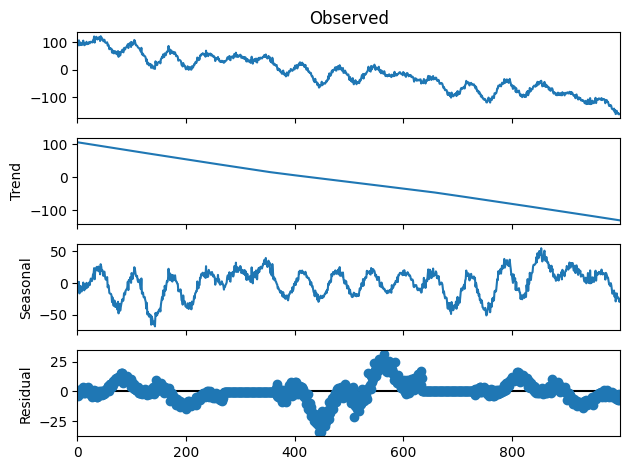

In [5]:
from statsmodels.tsa.seasonal import STL  # я выбрал именно STL вместо seasonal_decompose, чтобы по краям не было пустых значений

stl_result = STL(values, period=365).fit()
stl_result.plot()
plt.show()

#### Преобразование датасета

Исходный датасет сначала нужно преобразовать в иной формат, где на вход поступают N временных шагов, а на выход идёт следующий

К примеру, есть ряд `[1, 2, 3, 4, 5, 6, 7, 8, 9]`. Мы хотим разбить его на 3 временных шага, то есть на входе будут 3 элемента массива, а на выходе будет один следующий. Выглядеть это будет так:

```
input     | output
[1, 2, 3] | 4
```

Далее, продолжим таким образом идти по датасету до конца, получаем:

```
input     | output
[1, 2, 3] | 4
[2, 3, 4] | 5
[3, 4, 5] | 6
[4, 5, 6] | 7
[5, 6, 7] | 8
[6, 7, 8] | 9
```

Количество временных шагов подбирается эмпирически, это число не должно быть слишком большим (переобучение) или слишком маленьким (недообучение). Т.к. сезонность и тренд уже были вычленены из ряда, то кол-во шагов можно взять меньше, чем длина одного сезона

In [6]:
def split_values(values, time_steps):
    X, y = [], []
    i = 0

    while i + time_steps < len(values):  # чтобы не выйти за пределы массива
        X.append(values[i : i + time_steps])
        y.append(values[i + time_steps])
        i += 1
        
    return np.array(X), np.array(y)

In [7]:
time_steps = 30

X, y = split_values(stl_result.resid, time_steps)

На этом преобразования не закончились. CNN рассчитывает, что вводные данные будут подаваться в формате `[samples, timesteps, features]`. Здесь samples - сколько всего вводных данных, timesteps - кол-во временных шагов, а features - кол-во признаков. Т.к. ряд одномерный, то кол-во признаков равно 1. Перед подачей данных в модель, преобразуем их в нужный формат 

In [8]:
samples, features = X.shape[0], 1

X = X.reshape((samples, time_steps, features))

#### Создание модели

Итак, строим саму модель. Для этого я решил использовать TensorFlow и Keras, т.к. по-моему реализация через них конкретно для этой задачи будет самой простой

Здесь будем использовать одномерную модель CNN, т.к. у нас изменения происходят лишь в одной плоскости - время

Определяем 2 сверточных слоя с 32 картами фильтров на каждый и размерами ядра 3. Было выбрано 2 слоя с целью того, чтобы модель лучше улавливала паттерны. За ними следует слой среднего пула. Почему именно среднего? Потому что он устойчив к шуму и потому что ряд стационарный. Затем в конце задан выходной слой, который прогнозирует одно числовое значение.

Модель подбирается с использованием эффективной версии стохастического градиентного спуска Адама и оптимизируется с использованием среднеквадратичной ошибки, или «mse», функции потерь.

In [9]:
from tensorflow.keras import models, layers

model = models.Sequential([
    layers.Conv1D(32, 3, activation='relu', input_shape=(time_steps, features)),
    layers.Conv1D(32, 3, activation='relu'),
    layers.GlobalAveragePooling1D(),
    layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse')

2025-12-24 00:39:51.845441: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/owner/.python_env/local/lib/python3.13/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):
/home/owner/.python_env/local/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1766529593.565901  131823 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/d

In [10]:
model.fit(X, y, epochs=200, batch_size=32, validation_split=0.2, verbose=0)

2025-12-24 00:39:55.018282: I external/local_xla/xla/service/service.cc:163] XLA service 0x7effd0003e40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-24 00:39:55.018301: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2025-12-24 00:39:55.039419: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-24 00:39:55.151359: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002
I0000 00:00:1766529596.108009  131911 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


#### Предсказание

In [11]:
future = []
current = X[-1].copy()  # последние вводные данные в количестве time_steps 

for i in range(days_forecast):
    pred = model.predict(current.reshape(1, time_steps, 1), verbose=0)  # предсказываем по предыдущим вводным данным
    future.append(pred[0,0])
    current = np.roll(current, -1)  # сдвигаем вводные данные влево, тем самым образом первый элемент стал последним
    current[-1] = pred  # последним элементом должно быть предсказанное значение

#### Добавление тренда и сезонности

Добавляем их по аналогии с 1 лабой

##### Сезонность

In [12]:
season_days = 66  # определяется из графика сезонности

seasonal_forecast = stl_result.seasonal[-season_days:][:days_forecast]

seasonal_last = stl_result.seasonal[-season_days:]    
seasonal_forecast = np.tile(seasonal_last, days_forecast // season_days + 1)[:days_forecast]  # если прогноз делается на большее кол-во дней, чем сезон

##### Тренд

In [13]:
from sklearn.linear_model import LinearRegression

X = np.arange(days).reshape(-1, 1)

model = LinearRegression().fit(X, stl_result.trend)

X_future = np.arange(days, days+days_forecast).reshape(-1, 1)
trend_forecast = model.predict(X_future)

#### Итоговое предсказание

In [14]:
forecast = trend_forecast + seasonal_forecast + future

### Задание 3. Метрики

In [15]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

In [16]:
mean_absolute_error(values_true, forecast)

17.503740234936675

In [17]:
root_mean_squared_error(values_true, forecast)

22.340793206573426

Значения метрик MAE и RMSE не очень большие, а значит модель имеет приемлемую точность

### Задание 4. Отрисовка конечного результата

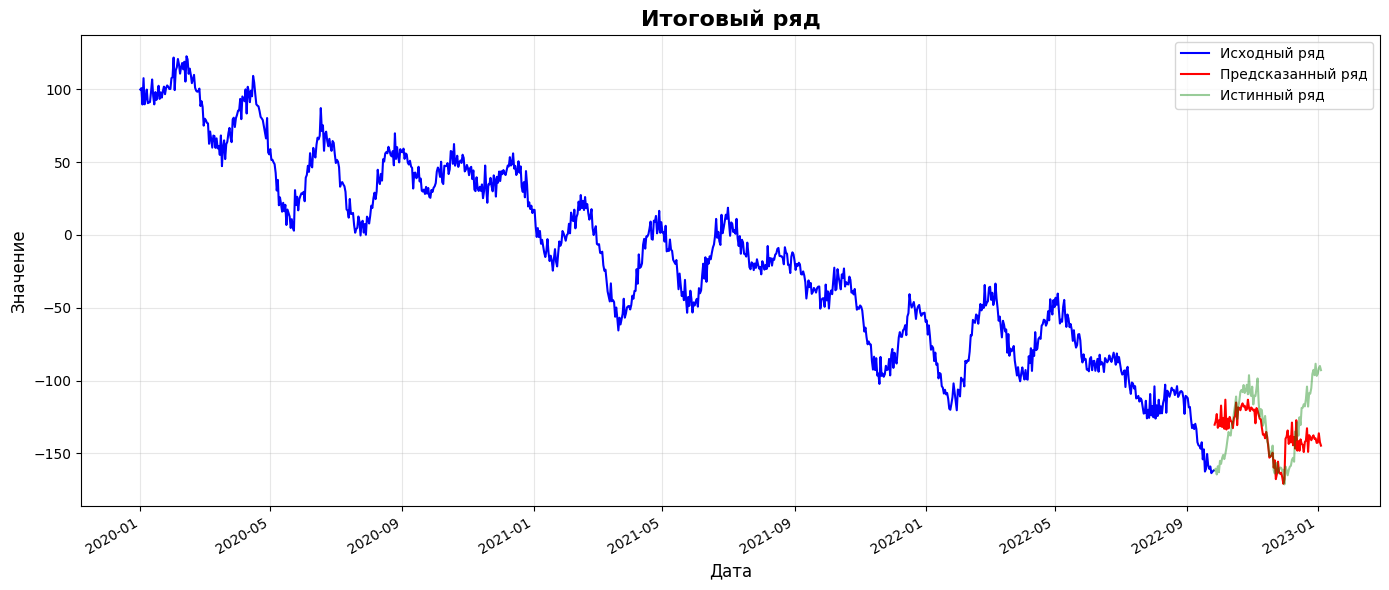

In [18]:
# Преобразуем строки дат в объекты datetime для matplotlib
dates_format = [datetime.strptime(date_str, '%Y-%m-%d') for date_str in dates]
dates_forecast_format = [datetime.strptime(date_str, '%Y-%m-%d') for date_str in dates_forecast]

plt.figure(figsize=(14, 6))

# Строим график временного ряда
plt.plot(dates_format, values, label='Исходный ряд', color='blue', linewidth=1.5)
plt.plot(dates_forecast_format, forecast, label='Предсказанный ряд', color='red', linewidth=1.5)
plt.plot(dates_forecast_format, values_true, label='Истинный ряд', color='green', linewidth=1.5, alpha=0.4)
plt.title('Итоговый ряд', fontsize=16, fontweight='bold')
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Значение', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

# Автоматически форматируем ось X для дат
plt.gcf().autofmt_xdate()

plt.tight_layout()

plt.show()

### Задание 5. Заключение

Сравнивая результаты лабы 1 и 2 можно прийти к выводу, что оба метода достаточно хороши для предсказания временного ряда. Значения ошибок у CNN получились несколько больше, чем у ARMA, но это можно обусловить тем, что параметры подбирались эмпирически. В плане реализации оба метода имеют свои особенности, так что сложно сказать, кто из них легче. По скорости работы CNN медленнее, но это происходит потому, что модель должна некоторое время обучиться.